# The Cart Decision Trees Classifier


## Introduction
  Decision trees is one of the most powerful machine learning algorithmes today, although its simplicity. it has many implementations. one of it is the **CART (Classification and Regression Tree)** algorithme.
In this notebook we will implement its whole class (ready to import and use) for classification from scratch, with its main methods (fit, predict, accuracy_score, predict proba, print_tree), using just **numpy** and **pandas** built-in functions. 

**Note:** this implementation is based on the CART algorithme main idea, but it is totaly my own implementation. So you can find a totaly different implementation in another place.

## Import libraries

In [1]:
import pandas as pd
import numpy as np

## The tree class
As the name (Decision Trees) refers. we are about built a Tree that has -*in each node*- a condition (or T/F question) from these questions, it will predict the class of the input instance. the figure below will show you the tree after training the algorithme.

<img src="https://i.stack.imgur.com/rWI9n.png" alt="img.png" width=300 align="center"></img>

Each node prepresent a step (the actual subset, its properties and the condition to split it), below the meaning of the properties:

- **samples:** the number of instances in the subset
- **gini:** the impurity of the subset (will be explained later) [0.0 .. 0.667]
- **value:** list of thr number of instances in each class [class0, class1, ...]
- **class:** the predicted class in this subset

In [2]:
class Tree:
    
    # the condition
    k = 0
    tk = 0.0
    
    # properties
    gini = 0.0
    samples = 0
    value = [0, 0, 0]
    classs = 0

    # childs
    leftChild = None
    rightChild = None
     
        
    def __init__(self):
        pass
    
    # print the actual node information
    def printNode(self):     
        print(f"""
        condition: feature{self.k} <= {self.tk}
        gini: {self.gini}
        samples: {self.samples}
        value: {self.value}
        class: {self.classs}
        """)
            
    # fill actual node by these values
    def insertValues(self, gini, samples, value, classs):
        self.gini = gini
        self.samples = samples
        self.value = value
        self.classs = classs

## The essential functions
To make the DecisionTree class as simple as possible, we will implement the big functions separately. then we will call them frim the class: 

### The fit (training) function
This is the function that will implement the whole training algorithme. 
The algorithm works by first splitting the training set into two subsets using a single feature k and a threshold tk (e.g., “petal length ≤ 2.45 cm”). It searches for the pair (k, tk) among (nb_features x nb_thresholds) combinations that produces the purest subsets (that minimizes the following cost function).
> **J(k, tk) = (minf/m)Ginf + (msup/m)Gsup**
> Where: 
> - minf: is the number of instances of the left subset (featurek <= tk)
> - msup: is the number of instances of the right subset (featurek > tk)
> - Ginf: the gini impurity of the left subset, it's given by:
> <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTz9ccYH9nPMErStcOZysZIzBGfwyKSYhXvcUh674VZ52kLcY4XhM2ymUzYnNdEueH6zLc" alt="impurity">

> - Gsup: the gini impurity of the right subset

Once the CART algorithm has successfully split the training set in two, it splits the
subsets using the same logic, then the sub-subsets, and so on, recursively. It stops
recursing once it reaches the maximum depth (max_depth = actual_depht), or the subset is pure, or it reaches the minimum number of samples to split (nb_instances < min_samples).

Once the training finished, it returns a full tree (like previous tree).

In [3]:
import warnings
warnings.filterwarnings('error')
# Note: for some iterations "gsup" take a very small value which cause the "RuntimeWarning". so we will filter the
# warnings as errors so that we can catch it by "try block"


def fit_dt(X, y, min_samples=None, max_depth=None, actual_depht=0):
    
    tree = Tree()
    
    # set default values
    if min_samples is None:
        min_samples = 2
    if max_depth is None:
        max_depth = 2
     
    m = X.shape[0]  # number of samples
    bestK = 0       # best feature to split
    bestTK = 0      # best threshold to split
    
    # stop conditions (min_sample/max_depth reached or the subset is pure)
    if min_samples <= X.shape[0] and max_depth > actual_depht and len(set(y)) != 1:
    
        bestCost = 1

        # search for the best combination to split
        for k in range(X.shape[1]):
            kmin = X[:, k].min()
            kmax = X[:, k].max()
            thresholds = np.linspace(kmin, kmax, 300, endpoint=False)[1:]   # list of 300 thresholds ]kmim...kmax[

            for tk in thresholds:
                yinf = y[X[:, k]<=tk]  
                minf = yinf.shape[0]
                ginf = 1 - ((yinf==0).sum() / minf) ** 2 - ((yinf==1).sum() / minf) ** 2 - ((yinf==2).sum() / minf) ** 2
                ysup = y[X[:, k]>tk]
                msup = ysup.shape[0]
                try:
                    gsup = 1 - (np.divide([(ysup==0).sum(), (ysup==1).sum(), (ysup==2).sum()], msup) ** 2).sum()
                except RuntimeWarning:
                    gsup = 0  # the warning means that gsup take very small values (close to 0)

                cost = (minf/m)*ginf + (msup/m)*gsup
                
                # update the best (feature/threshold), and the properties of the two subsets (the result of the split)
                if cost < bestCost:
                    bestCost = cost
                    bestK = k
                    bestTK = tk
                    gini1 = ginf
                    gini0 = gsup
                    samples1 = minf
                    samples0 = msup
                    value1= [(yinf==0).sum(), (yinf==1).sum(), (yinf==2).sum()]
                    value0= [(ysup==0).sum(), (ysup==1).sum(), (ysup==2).sum()]
                    class1 = np.argmax(value1)
                    class0 = np.argmax(value0)

        # split the left subset (best_feature <= best_threshold) with the same way
        tree.leftChild = fit_dt(X[X[:, bestK]<=bestTK], y[X[:, bestK]<=bestTK], min_samples, max_depth, actual_depht+1)
        # insert the properties of the left subset
        tree.leftChild.insertValues(gini1, samples1, value1, class1)
        
        # the same thing..
        tree.rightChild = fit_dt(X[X[:, bestK]>bestTK], y[X[:, bestK]>bestTK], min_samples, max_depth, actual_depht+1)
        tree.rightChild.insertValues(gini0, samples0, value0, class0)
        
        # save the best splitting condition (feature/threshold)
        tree.k = bestK
        tree.tk = bestTK
     
    # fill the root node by its properties (initial training set properties)
    if actual_depht == 0:
        tree.samples = m
        tree.value = [(y==0).sum(), (y==1).sum(), (y==2).sum()]
        tree.gini = 1 - (np.divide(tree.value, m) ** 2).sum()
        tree.classs = np.argmax(tree.value)
    
    return tree

### printDepthNodes function
This function print the nodes included in the input depth of the tree

In [4]:
def printDepthNodes(tree, depth=0, actualDepth=0):
    if actualDepth == depth:
        tree.printNode()
    else:
        if tree.leftChild is not None:
            printDepthNodes(tree.leftChild, depth, actualDepth+1) 
        if tree.rightChild is not None:
            printDepthNodes(tree.rightChild, depth, actualDepth+1)

### predictSample function
it returns the node of the subset that the input instance belong to

In [5]:
def predictSample(X, tree):
    
    if X[tree.k] <= tree.tk:  # go to left node if exist
        if tree.leftChild is not None:
            return predictSample(X, tree.leftChild)
        else:
            return tree
    else:                     # go to right node if exist
        if tree.rightChild is not None:
            return predictSample(X, tree.rightChild)
        else:
            return tree

## The CartDecisionTree Class implementation
Finaly here is the whole class implementation, with all its methods

In [6]:
class CartDecisionTree:
    
    model = Tree()
    
    def __init__(self):
        pass
    
    # the class methods
    
    def fit(self, X, y, min_samples=None, max_depth=None):
        self.model = fit_dt(X, y, min_samples, max_depth)
        print(f"CartDecisionTree(X, y, min_samples={min_samples}, max_depth={max_depth})")
    
    def predict(self, X):
        return np.array([predictSample(x, self.model).classs for x in X])   # numpy.array type of predictions
        
    def print_tree(self, depth=0):                                      # print a subtree of input depth
        for d in range(depth+1):
            print(f'depth: {d}')
            printDepthNodes(self.model, d)
        
    def accuracy_score(self, X, y):                                         # return the model accuracy [0.0 ... 1.0]
        return (self.predict(X) == y).sum() / X.shape[0]
    
    def predict_proba(self, X):                                             # return the class probabilities of X
        pred = predictSample(X, self.model)
        return np.divide(pred.value, pred.samples)
        

## Testing
we will try to test the algorithme and its accuracy on the **Iris dataset** to ensure that there is no logical problem.

#### import the data

In [8]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

#### data visualisation
we will plot the dataset using *sepal width* and *petal length* features.

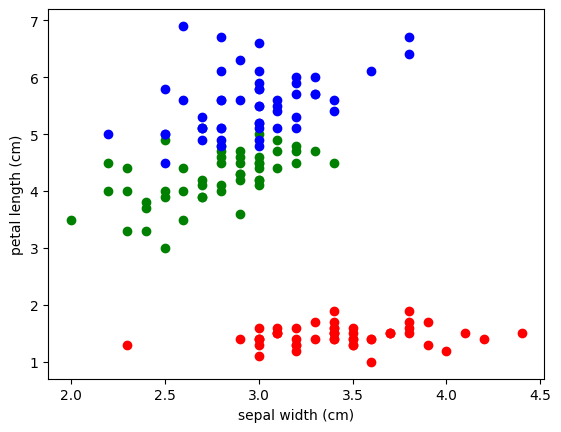

In [9]:
import matplotlib.pyplot as plt


styling = ((0, 'r'), (1, 'g'), (2, 'b'))

for label, color in styling:
    plt.scatter(X[y == label, 1], X[y == label, 2], c=color)

plt.xlabel('sepal width (cm)')
plt.ylabel('petal length (cm)')

plt.show()

#### class instanciation and fitting the model

In [10]:
dt_clf = CartDecisionTree()
dt_clf.fit(X, y, max_depth=5)

CartDecisionTree(X, y, min_samples=None, max_depth=5)


#### make prediction

In [11]:
dt_clf.predict([X[0]])

array([0], dtype=int64)

In [12]:
y[0]

0

#### predict the probability of an instance

In [13]:
dt_clf.predict_proba(X[112])

array([0., 0., 1.])

#### Tree visualisation

In [14]:
dt_clf.print_tree(5)

depth: 0

        condition: feature2 <= 1.9046666666666667
        gini: 0.6666666666666667
        samples: 150
        value: [50, 50, 50]
        class: 0
        
depth: 1

        condition: feature0 <= 0.0
        gini: 0.0
        samples: 50
        value: [50, 0, 0]
        class: 0
        

        condition: feature3 <= 1.7000000000000002
        gini: 0.5
        samples: 100
        value: [0, 50, 50]
        class: 1
        
depth: 2

        condition: feature2 <= 4.904
        gini: 0.1680384087791495
        samples: 54
        value: [0, 49, 5]
        class: 1
        

        condition: feature2 <= 4.8069999999999995
        gini: 0.04253308128544431
        samples: 46
        value: [0, 1, 45]
        class: 2
        
depth: 3

        condition: feature3 <= 1.6019999999999999
        gini: 0.040798611111111174
        samples: 48
        value: [0, 47, 1]
        class: 1
        

        condition: feature3 <= 1.5
        gini: 0.4444444444444444
        s

#### calculate the accuracy score of the model

In [15]:
dt_clf.accuracy_score(X, y)

1.0

it is amazing on the training set! you can test it yourself using cross validation set.

# Thanks